In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import re

In [72]:
# my deltapsi- scatterplot : lc deltapsi vs. my deltapsi #
# table = table[table.deltapsi > 0] # mut-unmut >1
mucll=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/mean_std_junction/deltapsi_analysis2.csv", usecols=[0,5])
mucll["deltapsi"]= mucll["deltapsi"].astype(float)
mucll = mucll[mucll.deltapsi > 0]
ucll=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/mean_std_junction/deltapsi_analysis6.csv", usecols=[0,5])
ucll["deltapsi"]= ucll["deltapsi"].astype(float)
ucll = ucll[ucll.deltapsi > 0]
mcll=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/mean_std_junction/deltapsi_analysis4.csv", usecols=[0,5])
mcll["deltapsi"]= mcll["deltapsi"].astype(float)
mcll = mcll[mcll.deltapsi > 0]

In [73]:
table = pd.merge(mcll,ucll, how='outer',on="junction",suffixes=["_m","_u"])
table=pd.merge(table, mucll, how='outer',on="junction")
table["max_deltapsi"]=table.max(axis="columns")

/home/ls/rachelcw/miniconda3/envs/bio_sns/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


In [74]:
table = table[table.max_deltapsi > 0]
table=table.sort_values('deltapsi', ascending=False)
table.drop_duplicates(subset='junction',keep='first', inplace=True)
table["junction"]=table["junction"].str.replace('chr','')
table=table.filter(items=["junction","max_deltapsi"])


In [61]:
# # effect size tables # #
#FDR - 0.05
mcll=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.05/filtered.a4.20230115_effect_sizes.txt",sep=' ')
ucll=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.05/filtered.a6.20230115_effect_sizes.txt",sep=' ')
mucll=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.05/filtered.a2.20230115_effect_sizes.txt",sep=' ')

table_lc = pd.merge(mcll[['intron','unmut','mut','deltapsi']],ucll[['intron','unmut','mut','deltapsi']], how='outer')
table_lc=pd.merge(table_lc, mucll[['intron','unmut','mut','deltapsi']], how='outer')
table_lc=table_lc.sort_values('deltapsi', ascending=False)
table_lc.drop_duplicates(subset='intron',keep='first', inplace=True)
table_lc["intron"]=table_lc["intron"].str.replace("chr","")
table_lc=table_lc[table_lc.deltapsi > 0]

,max_deltapsi,deltapsi
max_deltapsi,1.000000,0.681219
deltapsi,0.681219,1.000000


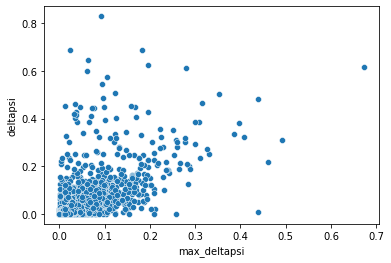

In [69]:
scatter_table=table.merge(table_lc.filter(items=["intron","deltapsi"]),how="inner",left_on="junction", right_on="intron",indicator=True)
scatter_table.dropna(axis=0,inplace=True)
sns.scatterplot(x=scatter_table["max_deltapsi"],y=scatter_table["deltapsi"])
scatter_table.drop(columns=["intron","_merge"], inplace=True)
scatter_table.set_index("junction")
scatter_table.corr(method="spearman")

In [75]:
table=table.filter(items=["junction","max_deltapsi"])
table.rename(columns={"junction":"intron","max_deltapsi":"deltapsi"},inplace=True)
table[['junction','cluster']]=table['intron'].str.rsplit(':',expand=True,n=1)

In [76]:
table["chrom"]=table['intron'].str.rsplit(':',expand=True,n=3)[0]
# table["chrom"]=table["chrom"].str.replace('chr','')

In [77]:
# loading gtf file- only protein coding #
import pyensembl
table['gene_name']=pd.NaT
# table['identified']=pd.NaT
data = pyensembl.Genome(
    reference_name='GRCh37',
    annotation_name='my_genome_lab',
    gtf_path_or_url='/home/ls/rachelcw/projects/protein_coding.gtf')
data.index()

# gene name per junction #
for i,j in enumerate(table.junction):
    j=j.split(':')
    chr=j[0].replace('chr','')
    start=int(j[1])
    end=int(j[2])
    gene_name = data.gene_names_at_locus(contig=chr, position=start,end=end)
    if gene_name != []:
        table.at[i,'gene_name']=gene_name
    

table.dropna(subset=['gene_name'], inplace=True)

In [27]:
# reads count per juction #
counts_read=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/lc_20230108/lc_20230108_perind_numers.counts.gz", sep=' ',compression='gzip')

In [78]:
cll_data=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/cll_data.csv")
cll_data=cll_data[cll_data["SF3B1_mut"]=="Mutated SF3B1"]

In [79]:
junction_list=list(table["intron"])
counts_junction=counts_read[counts_read.index.isin(junction_list)]

counts=[np.sum(x) for x in counts_junction.values]
counts_table=pd.DataFrame({"counts":counts},index=counts_junction.index)
table=table.merge(counts_table,how="left",left_on="intron",right_index=True)

In [80]:
# the junction (event) is identified in GTF (known 5, known 3, known junction, novel), add strand column (+\-) #
fiveprime=pd.read_csv("/home/ls/rachelcw/projects/BIO/annontation_code.20221225_fiveprime.bed.gz", sep='\t',compression='gzip', header=None,usecols=[0,1,5,8] ,names=['chrom', 'start_int',  'strand','type'])
fiveprime['chrom'] = fiveprime['chrom'].astype(str)
fiveprime= fiveprime.loc[(fiveprime.type=='protein_coding')]
threeprime=pd.read_csv("/home/ls/rachelcw/projects/BIO/annontation_code.20221225_threeprime.bed.gz", sep='\t',compression='gzip', header=None, usecols=[0,1,5,8] ,names=['chrom', 'start_int',  'strand','type'])
threeprime['chrom'] = threeprime['chrom'].astype(str)
threeprime= threeprime.loc[(threeprime.type=='protein_coding')]
table['identified_gtf']=pd.NaT
table['strand']= pd.NaT

for chr in fiveprime.chrom.unique():
    fiveprime_chr=fiveprime.loc[fiveprime.chrom==chr]
    threeprime_chr=threeprime.loc[threeprime.chrom==chr]
    chr_table=table.loc[table.chrom==chr]
    for junc in chr_table.junction:
        junction=junc.split(':')
        # chr=junction[0].replace('chr','')
        start=int(junction[1])
        end=int(junction[2])
        identified= ""
        counter = 0
        if fiveprime_chr['start_int'].isin([start]).any():
            identified= "known 5'"
            counter = counter +1
            strand=list(fiveprime_chr.loc[fiveprime_chr.start_int==start,'strand'])[0]
            table.loc[table.junction==junc,'strand']=strand
        if threeprime_chr['start_int'].isin([end]).any():
            identified= "known 3'"
            counter = counter +1
            strand=list(threeprime_chr.loc[threeprime_chr.start_int==end,'strand'])[0]
            table.loc[table.junction==junc,'strand']= strand
        if counter == 2:
            identified = "known junction"
        if counter == 0:
            identified = "novel"
        table.loc[table.junction==junc,'identified_gtf']=identified
          

/home/ls/rachelcw/miniconda3/envs/bio_sns/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


[Text(0, 0, '438'), Text(0, 0, '2158'), Text(0, 0, '848')]

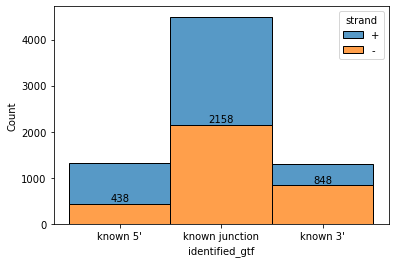

In [31]:
plot_table=table.filter(items=["intron","identified_gtf","strand"])
# plot_table.drop_duplicates(inplace=True)
ax=sns.histplot(data=plot_table, x='identified_gtf',hue='strand',multiple="stack")
# ax=sns.histplot(data=plot_table, x='identified gtf')
ax.bar_label(ax.containers[0])

In [81]:
# table of 5/3 known events #
# table_altss=table[table["identified_gtf"].str.contains("\d")]
table_altss=table

In [82]:
table_altss=table_altss.reset_index(drop=True)
table_altss["gene_by_strand"]= pd.NaT
for i,j in zip(table_altss["junction"].index,table_altss["junction"]):
    j=j.split(':')
    chr=j[0].replace('chr','')
    start=int(j[1])
    end=int(j[2])
    strand=table_altss["strand"].iloc[i]
    gene_name = data.gene_names_at_locus(contig=chr, position=start,end=end,strand=strand)
    table_altss.at[i,'gene_by_strand']=gene_name
    

InterfaceError: Error binding parameter 3 - probably unsupported type.

In [71]:
table_altss.loc[table_altss["deltapsi"]>=0.3, "gene_by_strand"]

0          GCC2
1     [CCDC88B]
2      [CEP135]
3        [GSAP]
4      [MAP3K7]
5        [DLG1]
6      [INPPL1]
7       [CASD1]
8        [CD72]
11      [ENOX2]
13     [ZNF737]
Name: gene_by_strand, dtype: object

In [45]:
table_altss=table_altss.reset_index(drop=True)
table_altss["gene_by_strand"]= pd.NaT
for i,j in zip(table_altss["junction"].index,table_altss["junction"]):
    j=j.split(':')
    chr=j[0].replace('chr','')
    start=int(j[1])
    end=int(j[2])
    strand=table_altss["strand"].iloc[i]
    gene_name = data.gene_names_at_locus(contig=chr, position=start,end=end,strand=strand)
    table_altss.at[i,'gene_by_strand']=gene_name
    

In [46]:
table_altss.drop(columns="gene_name",inplace=True)

In [47]:
# frameshift #
table_altss['frameshift']=pd.NaT
table_altss['length_junction']=pd.NaT
for junc in table_altss.junction:
    junction=junc.split(':')
    start=int(junction[1])
    end=int(junction[2])
    size=end-start
    if size%3==0:
        table_altss.loc[table_altss.junction==junc,'frameshift']="0"
    else:
        table_altss.loc[table_altss.junction==junc,'frameshift']="1"
    table_altss.loc[table_altss.junction==junc,'length_junction']=size
table_altss['frameshift'].value_counts()
# table of no frameshift events #
no_frameshift=table_altss[table_altss["frameshift"].str.contains("0")]

In [48]:
# essential gene #
# gene_dep=pd.read_csv("/home/ls/rachelcw/projects/CRISPR_gene_dependency.csv")
essential_gene=pd.read_csv("/home/ls/rachelcw/projects/CRISPRInferredCommonEssentials.csv")
pattern=re.compile("\\(*\d*\\)")
essential_gene["Essentials"]=essential_gene["Essentials"].str.replace(pattern,'')
essential_gene["Essentials"]=essential_gene["Essentials"].str.replace(" ",'')
essential_gene_list=essential_gene["Essentials"].to_list()

In [52]:
no_frameshift["essential"]=pd.NaT
for i,gene in zip(no_frameshift["gene_by_strand"].index,no_frameshift["gene_by_strand"]):
    esn=""
    if len(gene)>1:
        no_frameshift.loc[i,"essential"]="check"
    else:
        
        if gene[0] in essential_gene_list:
            no_frameshift.loc[i,"essential"]="1"
        else:
            no_frameshift.loc[i,"essential"]="0"

/home/ls/rachelcw/miniconda3/envs/bio_sns/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ls/rachelcw/miniconda3/envs/bio_sns/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


[Text(0, 0, '32'), Text(0, 0, '717'), Text(0, 0, '139')]

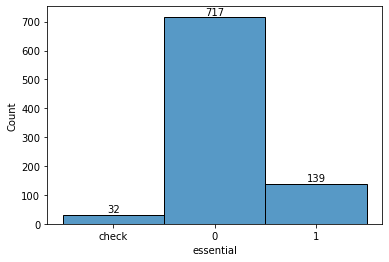

In [53]:
ax=sns.histplot(data=no_frameshift, x='essential')
ax.bar_label(ax.containers[0])

In [54]:
essential_no_frameshift=no_frameshift[no_frameshift["essential"].str.contains("1")]
